In [1]:
import numpy
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("dataset/train_data.csv")

In [3]:
df.YEAR.value_counts()

2017/18    6088
2018/19    5861
Name: YEAR, dtype: int64

In [4]:
df.columns

Index(['BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'POSTCODE', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'Borough', 'Latitude',
       'Longitude', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'NTA', 'New Georeferenced Column'],
      dtype='object')

# Data preprocessing

In [5]:
clusters = pd.read_csv("clusters.csv")
clusters = clusters.set_index("labels")

In [6]:
def find_closest_cluster(point, clusters):
    if np.sum(np.isnan(point)) > 0:
        return -1, 0
    dist = np.sqrt(np.sum((clusters - point)**2, axis=1))
    ind = np.argmin(dist)
    min_dist = np.min(dist)
    return ind, min_dist

In [7]:
def df_info(df):
    #print(df.info())
    return df

In [8]:
def select_columns(df, columns=[]):
    """
    Selects columns from `columns`
    """
    return df.loc[:,columns]

In [9]:
def encode_easement(df):
    df.EASEMENT = df.EASEMENT.apply(lambda x: int(len(str(x)) == 1))
    return df

In [10]:
def fix_stories(df):
    df.STORIES.fillna(0, inplace=True)
    return df

In [11]:
def calculate_dist(df):
    cl = []
    dist = []
    for point in zip(df.Latitude, df.Longitude):
        point = np.array(point)
        ind, mdis = find_closest_cluster(point, clusters=clusters)
        cl += [ind]
        dist += [mdis]
    df["cluster"] = cl
    df["dist"] = dist
    return df

In [12]:
def drop_columns(df, columns=["EASEMENT", "Latitude", "Longitude", "EXLAND", "EXTOT", "STORIES", "cluster"]):
    df = df.drop(columns=columns)
    return df

In [13]:
result = df.pipe(df_info) \
  .pipe(select_columns, columns=
          [
           "BORO",
           "EASEMENT",
           "TAXCLASS",
           "LTFRONT",
           "Latitude",
           "Longitude",
           "LTDEPTH",
           "AVTOT",
           "EXLAND",
           "EXTOT",
           "STORIES",
           "YEAR",
           "FULLVAL", # Y
           #"NTA",
           #"NTA_VAL",
           #"BORO_VAL",
           #"BLOCK_VAL"
          ]) \
  .pipe(fix_stories) \
  .pipe(encode_easement) \
  .pipe(calculate_dist) \
  .pipe(drop_columns)

In [14]:
result.columns

Index(['BORO', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'AVTOT', 'YEAR', 'FULLVAL',
       'dist'],
      dtype='object')

# Model training and predictions

In [15]:
threshold = 0.1e6

In [16]:
from pycaret.regression import *

In [17]:
smol = result[result.AVTOT > threshold]

In [18]:
s = setup(smol, target = 'FULLVAL')

,Description,Value
0,session_id,2891
1,Target,FULLVAL
2,Original Data,"(2920, 8)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2043, 18)"


In [19]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,208360.1663,2137901805343.5288,974714.7693,0.9643,0.2720,0.1471,0.1350
omp,Orthogonal Matching Pursuit,355097.4040,2439528584125.5024,1120970.4318,0.9614,0.4870,0.3646,0.0040
br,Bayesian Ridge,355107.2842,2439526587262.5674,1120972.5219,0.9614,0.4870,0.3646,0.0050
en,Elastic Net,347122.8873,2592527089579.3745,1236579.1293,0.9605,0.3817,0.2252,0.1140
lr,Linear Regression,382732.6631,2655845564817.8604,1267404.2091,0.9597,0.4470,0.2690,0.1880
lasso,Lasso Regression,188473.0143,2417401662953.9521,1015461.7945,0.9581,0.2355,0.1198,0.1510
llar,Lasso Least Angle Regression,188557.0825,2417759250783.4033,1015480.8742,0.9581,0.2367,0.1199,0.0050
et,Extra Trees Regressor,224721.7683,5532794161834.9883,1682764.0175,0.9526,0.1758,0.0522,0.0620
knn,K Neighbors Regressor,568016.0121,27787340578493.3828,3271759.6825,0.9340,0.5784,0.3913,0.0080
rf,Random Forest Regressor,342782.1453,12976254650940.3320,2399067.6148,0.9309,0.2109,0.0783,0.0690


In [24]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [25]:
best

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=2891, solver='auto', tol=0.001)

# Save model 

In [26]:
finalize_model(best)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=2891, solver='auto', tol=0.001)

In [27]:
save_model(best, 'big_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='FULLVAL',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy...
                 ('dummy', Dummify(target='FULLVAL')),
                 ('fix_perfect', Remove_100(target='FULLVAL')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthr

# Predict new data

In [29]:
best = load_model('big_pipeline')

Transformation Pipeline and Model Successfully Loaded


## Load and transform new data

In [30]:
new_data = pd.read_csv("test.csv")

In [31]:
X_new = new_data.pipe(df_info) \
  .pipe(select_columns, columns=
          [
           "BORO",
           "EASEMENT",
           "TAXCLASS",
           "LTFRONT",
           "Latitude",
           "Longitude",
           "LTDEPTH",
           "AVTOT",
           "EXLAND",
           "EXTOT",
           "STORIES",
           "YEAR",
           #"FULLVAL", # Y
           #"NTA",
           #"NTA_VAL",
           #"BORO_VAL",
           #"BLOCK_VAL"
          ]) \
  .pipe(fix_stories) \
  .pipe(encode_easement) \
  .pipe(calculate_dist) \
  .pipe(drop_columns)

In [32]:
X_new_smol = X_new[X_new.AVTOT >= threshold]

In [33]:
pred = predict_model(best, data = X_new_smol)

In [35]:
pred.Label.to_csv("pred_big.csv")

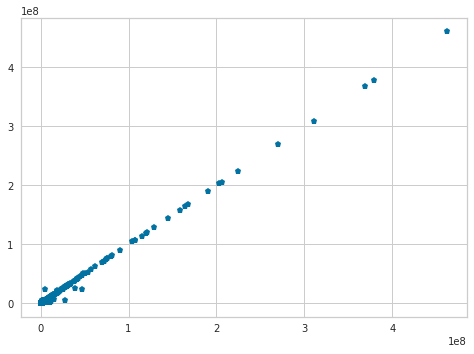

In [36]:
plt.plot(smol.FULLVAL, pred.Label, 'p')